# Lecture 3: Kernelization

**Making linear models non-linear**

Joaquin Vanschoren

In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip install -rq master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 1.5
else:
    fig_scale = 1.2

## Feature Maps
* Linear models: $\hat{y} = \mathbf{w}\mathbf{x} + w_0 = \sum_{i=1}^{p} w_i x_i + w_0 = w_0 + w_1 x_1 + ... + w_p x_p $  

* When we cannot fit the data well, we can add non-linear transformations of the features
* Feature map (or _basis expansion_ ) $\phi$ : $ X \rightarrow \mathbb{R}^d $

$$y=\textbf{w}^T\textbf{x} \rightarrow  y=\textbf{w}^T\phi(\textbf{x})$$  

* E.g. Polynomial feature map: all polynomials up to degree $d$ and all products

$$[1, x_1, ..., x_p] \xrightarrow{\phi} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$

* Example with $p=1, d=3$ :

$$y=w_0 + w_1 x_1 \xrightarrow{\phi} y=w_0 + w_1 x_1 + w_2 x_1^2 + w_3 x_1^3$$  


### Ridge regression example

Weights: [0.418]


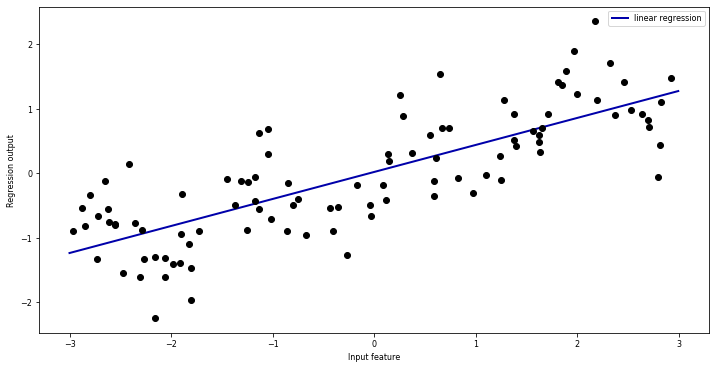

In [2]:
from sklearn.linear_model import Ridge

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = Ridge().fit(X, y)
print("Weights:",reg.coef_)
plt.rcParams['figure.figsize'] = [8*fig_scale, 4*fig_scale]
plt.plot(line, reg.predict(line), label="linear regression", lw=2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

* Add all polynomials $x^d$ up to degree 10 and fit again:
    * e.g. use sklearn `PolynomialFeatures`

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
styles = [dict(selector="td", props=[("font-size", "150%")]),dict(selector="th", props=[("font-size", "150%")])]
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head().style.set_table_styles(styles)

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.752759,0.566647,-0.426548,0.321088,-0.241702,0.181944,-0.136960,0.103098,-0.077608,0.058420
1,2.704286,7.313162,19.776880,53.482337,144.631526,391.124988,1057.713767,2860.360362,7735.232021,20918.278410
2,1.391964,1.937563,2.697017,3.754150,5.225640,7.273901,10.125005,14.093639,19.617834,27.307312
3,0.591951,0.350406,0.207423,0.122784,0.072682,0.043024,0.025468,0.015076,0.008924,0.005283
4,-2.063888,4.259634,-8.791409,18.144485,-37.448187,77.288869,-159.515582,329.222321,-679.478050,1402.366700


Weights: [ 0.643  0.297 -0.69  -0.264  0.41   0.096 -0.076 -0.014  0.004  0.001]


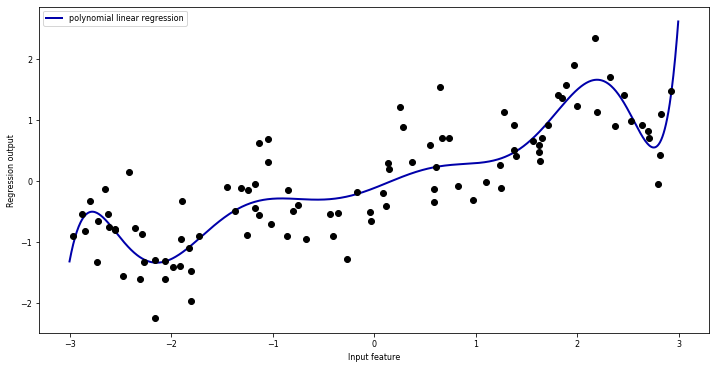

In [4]:
reg = Ridge().fit(X_poly, y)
print("Weights:",reg.coef_)
line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression', lw=2)
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

#### How expensive is this?

* You may need MANY dimensions to fit the data
    * Memory and computational cost
    * More weights to learn, more likely overfitting
* Ridge has a closed-form solution which we can compute with linear algebra:
$$w^{*} = (X^{T}X + \alpha I)^{-1} X^T Y$$

* Since X has $n$ rows (examples), and $d$ columns (features), $X^{T}X$ has dimensionality $d x d$
* Hence Ridge is quadratic in the number of features, $\mathcal{O}(d^2n)$
* After the feature map $\Phi$, we get
$$w^{*} = (\Phi(X)^{T}\Phi(X) + \alpha I)^{-1} \Phi(X)^T Y$$

* Since $\Phi$ increases $d$ a lot, $\Phi(X)^{T}\Phi(X)$ becomes _huge_

### Linear SVM example (classification)

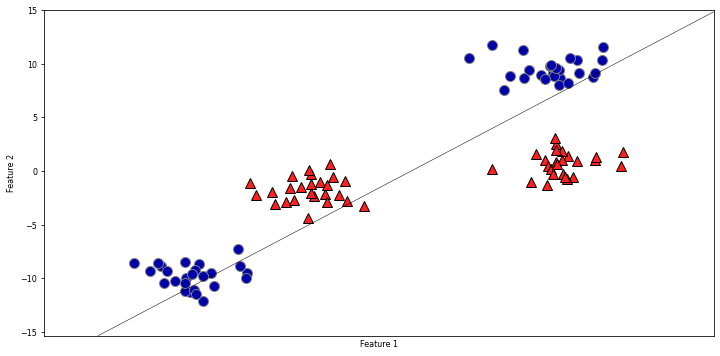

In [5]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

We can add a new feature by taking the squares of feature1 values

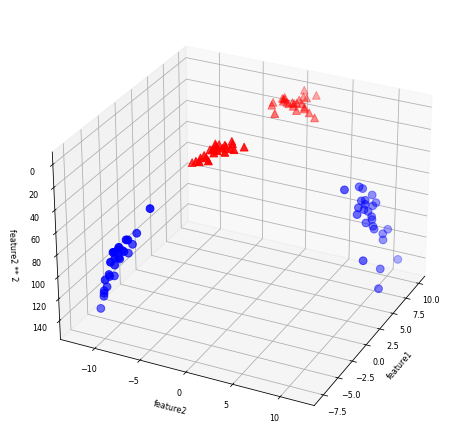

In [6]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])


from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)
ax.set_xlabel("feature1")
ax.set_ylabel("feature2")
ax.set_zlabel("feature2 ** 2");

Now we can fit a linear model

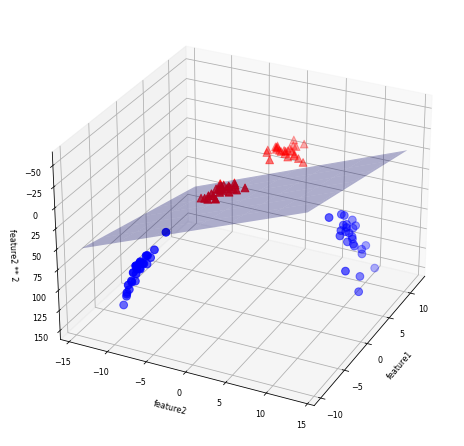

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60)

ax.set_xlabel("feature1")
ax.set_ylabel("feature2")
ax.set_zlabel("feature2 ** 2");

As a function of the original features, the decision boundary is now a polynomial as well
$$y = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_2^2 > 0$$

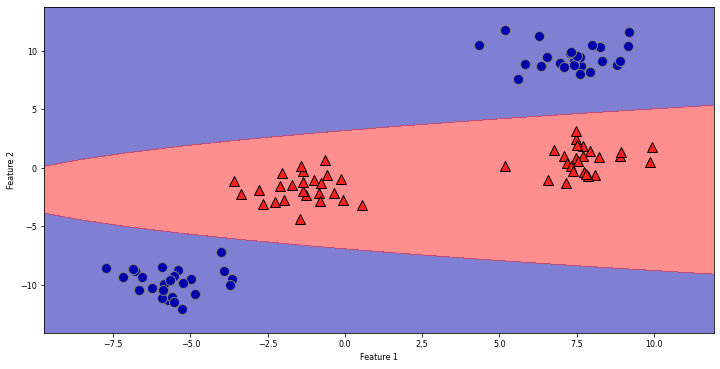

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2"); 

## The kernel trick
* Computations in explicit, high-dimensional feature maps are _expensive_
* For _some_ feature maps, we can, however, compute _distances_ between _points_ cheaply
    * Without explicitly constructing the high-dimensional space at all
* Example: _quadratic_ feature map for $\mathbf{x} = (x_1,..., x_p )$:

$$ \Phi(\mathbf{x}) = (x_1,..., x_p , x_1^2,..., x_p^2 , \sqrt{2} x_1 x_2 , ..., \sqrt{2} x_{p-1} x_{p}) $$

* A _kernel function_ exists for this feature map to compute dot products

$$ k_{quad}(\mathbf{x_i},\mathbf{x_j}) =  \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j}) =  \mathbf{x_i} \cdot \mathbf{x_j} + (\mathbf{x_i} \cdot \mathbf{x_j})^2$$

* Skip computation of $\Phi(x_i)$ and $\Phi(x_j)$ and compute $k(x_i,x_j)$ directly

## Kernelization

* Kernel $k$ corresponding to a feature map $\Phi$: $ k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$
* Computes dot product between $x_i,x_j$ in a high-dimensional space $\mathcal{H}$
    * Kernels are sometimes called _generalized dot products_
    * $\mathcal{H}$ is called the _reproducing kernel Hilbert space_ (RKHS)
* The dot product is a measure of the _similarity_ between $x_i,x_j$
    * Hence, a kernel can be seen as a similarity measure for high-dimensional spaces
* If we have a loss function based on dot products $\mathbf{x_i}\cdot\mathbf{x_j}$ it can be _kernelized_
    * Simply replace the dot products with $k(\mathbf{x_i},\mathbf{x_j})$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/RKHS.png" alt="ml" style="margin: 0 auto; width: 900px;"/>

### Example: SVMs

* Linear SVMs (dual form, for $l$ support vectors with dual coefficients $a_i$ and classes $y_i$):
$$\mathcal{L}_{Dual} (a_i) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j (\mathbf{x_i} . \mathbf{x_j}) $$
* Kernelized SVM, using any existing kernel $k$ we want:
$$\mathcal{L}_{Dual} (a_i, k) = \sum_{i=1}^{l} a_i - \frac{1}{2} \sum_{i,j=1}^{l} a_i a_j y_i y_j k(\mathbf{x_i},\mathbf{x_j}) $$

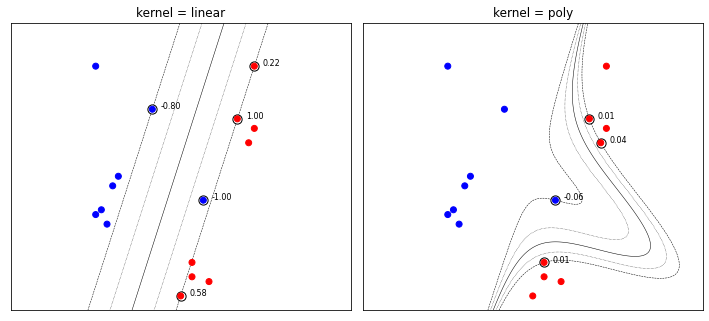

In [9]:
from sklearn import svm

def plot_svm_kernels(kernels, poly_degree=3, gamma=2, C=1, size=4):
    # Our dataset and targets
    X = np.c_[(.4, -.7),
              (-1.5, -1),
              (-1.4, -.9),
              (-1.3, -1.2),
              (-1.1, -.2),
              (-1.2, -.4),
              (-.5, 1.2),
              (-1.5, 2.1),
              (1, 1),
              # --
              (1.3, .8),
              (1.2, .5),
              (.2, -2),
              (.5, -2.4),
              (.2, -2.3),
              (0, -2.7),
              (1.3, 2.1)].T
    Y = [0] * 8 + [1] * 8

    # figure number
    fig, axes = plt.subplots(1, len(kernels), figsize=(len(kernels)*size*1.1*fig_scale, size*fig_scale), tight_layout=True)
    if len(kernels) == 1:
        axes = [axes]
    if not isinstance(gamma,list):
        gamma = [gamma]*len(kernels)
    if not isinstance(C,list):
        C = [C]*len(kernels)
    # fit the model
    for kernel, ax, g, c in zip(kernels,axes,gamma,C):
        clf = svm.SVC(kernel=kernel, gamma=g, C=c, degree=poly_degree)
        clf.fit(X, Y)

        # plot the line, the points, and the nearest vectors to the plane
        if kernel == 'rbf':
            ax.set_title(r"kernel = {}, $\gamma$={}, C={}".format(kernel, g, c), fontsize=12)
        else:
            ax.set_title('kernel = %s' % kernel, fontsize=12)

        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    s=85, edgecolors='k', c='w', zorder=10)
        ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.bwr)

        for i, coef in enumerate(clf.dual_coef_[0]):
            ax.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.15,clf.support_vectors_[i, 1]), fontsize=8, zorder=11)

        ax.axis('tight')
        x_min = -3
        x_max = 3
        y_min = -3
        y_max = 3

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k', 'k', 'k'], linestyles=['--', ':', '-', ':', '--'],
                    levels=[-1, -0.5, 0, 0.5, 1])

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
plot_svm_kernels(['linear', 'poly'],poly_degree=3,size=3)

### Which kernels exist?

* A (Mercer) kernel is any function $k: X \times X \rightarrow \mathbb{R}$ with these properties:
    - Symmetry: $k(\mathbf{x_1},\mathbf{x_2}) = k(\mathbf{x_2},\mathbf{x_1}) \,\,\, \forall \mathbf{x_1},\mathbf{x_2} \in X$
    - Positive definite: the kernel matrix $K$ is positive semi-definite
        - Intuitively, $k(\mathbf{x_1},\mathbf{x_2}) \geq 0$
        
* The kernel matrix (or Gram matrix) for $n$ points of $x_1,..., x_n \in X$ is defined as:

$$ K = XX^T = \begin{bmatrix}
                    k(\mathbf{x_1}, \mathbf{x_1}) & \ldots & k(\mathbf{x_1}, \mathbf{x_n}) \\
                    \vdots & \ddots & \vdots \\
                    k(\mathbf{x_n}, \mathbf{x_1})  & \ldots & k(\mathbf{x_n}, \mathbf{x_n})
                  \end{bmatrix}
                  $$
                  
* Once computed ($\mathcal{O}(n^2)$), simply lookup $k(\mathbf{x_1}, \mathbf{x_2})$ for any two points
* In practice, you can either supply a kernel function or precompute the kernel matrix

### Linear kernel
* Input space is same as output space: $X = \mathcal{H} = \mathbb{R}^d$
* Feature map $\Phi(\mathbf{x}) = \mathbf{x}$
* Kernel: $ k_{linear}(\mathbf{x_i},\mathbf{x_j}) = \mathbf{x_i} \cdot \mathbf{x_j}$
* Geometrically, the dot product is the _projection_ of $\mathbf{x_j}$ on hyperplane defined by $\mathbf{x_i}$
    * Becomes larger if $\mathbf{x_i}$ and $\mathbf{x_j}$ are in the same 'direction'
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/05_dotproduct.png" alt="ml" style="margin: 0 auto; width: 300px;"/>

* Linear kernel between point (0,1) and another unit vector an angle $a$ (in radians)
    * Points with similar angles are deemed similar

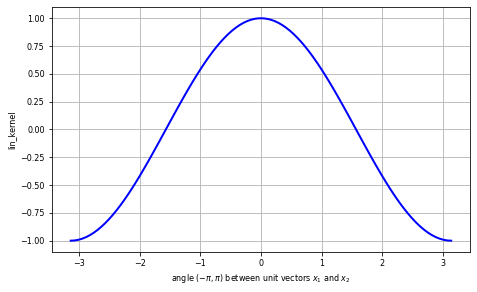

In [10]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
import math
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

def plot_lin_kernel():
    fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
    x = np.linspace(-math.pi,math.pi,100)
    # compare point (0,1) with unit vector at certain angle
    # linear_kernel returns the kernel matrix, get first element
    ax.plot(x,[linear_kernel([[1,0]], [[math.cos(i),math.sin(i)]])[0] for i in x],lw=2,c='b',label='', linestyle='-')
    ax.set_xlabel("angle $(-\pi,\pi)$ between unit vectors $x_1$ and $x_2$")
    ax.set_ylabel("lin_kernel")
    plt.grid()
plot_lin_kernel()

### Polynomial kernel
- If $k_1$, $k_2$ are kernels, then $\lambda . k_1$ ($\lambda \geq 0$), $k_1 + k_2$, and $k_1 . k_2$ are also kernels
- The __polynomial kernel__ (for degree $d \in \mathbb{N}$) reproduces the polynomial feature map
    - $\gamma$ is a scaling hyperparameter (default $\frac{1}{p}$)
    - $c_0$ is a hyperparameter (default 1) to trade off influence of higher-order terms
$$k_{poly}(\mathbf{x_1},\mathbf{x_2}) = (\gamma (\mathbf{x_1} \cdot \mathbf{x_2}) + c_0)^d$$

In [11]:
@interact
def plot_poly_kernel(degree=(1,10,1), coef0=(0,2,0.5), gamma=(0,2,0.5)):
    fig, ax = plt.subplots(figsize=(5*fig_scale,3*fig_scale))
    x = np.linspace(-math.pi,math.pi,100)
    # compare point (0,1) with unit vector at certain angle
    if isinstance(degree,list):
        for d in degree:
            ax.plot(x,[polynomial_kernel([[1,0]], [[math.cos(i),math.sin(i)]], degree=d, coef0=coef0, gamma=gamma)[0]
                       for i in x],lw=2,label='degree = {}'.format(d), linestyle='-')    
    else:
        ax.plot(x,[polynomial_kernel([[1,0]], [[math.cos(i),math.sin(i)]], degree=degree, coef0=coef0, gamma=gamma)[0]
                   for i in x],lw=2,c='b',label='degree = {}'.format(degree), linestyle='-')    
    ax.set_xlabel("angle $(-\pi,\pi)$ between unit vectors $x_1$ and $x_2$")
    ax.set_ylabel("poly_kernel")
    plt.grid()
    plt.legend()

interactive(children=(IntSlider(value=5, description='degree', max=10, min=1), FloatSlider(value=1.0, descript…

In [12]:
if not interactive:
    plot_poly_kernel(degree=[2,3,5], coef0=1, gamma=None)

### RBF (Gaussian) kernel
- The _Radial Basis Function_ (RBF) feature map builds the Taylor series expansion of $e^x$
$$\Phi(x) = e^{-x^2/2\gamma^2} \Big[ 1, \sqrt{\frac{1}{1!\gamma^2}}x,\sqrt{\frac{1}{2!\gamma^4}}x^2,\sqrt{\frac{1}{3!\gamma^6}}x^3,\ldots\Big]^T$$

- RBF (or _Gaussian_ ) kernel with _kernel width_ $\gamma \geq 0$:    
$$k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}||^2)$$ 

In [13]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_rbf_kernel(gamma=(0.01,10,0.1)):
    fig, ax = plt.subplots(figsize=(4*fig_scale,3*fig_scale))
    x = np.linspace(-6,6,100)
    if isinstance(gamma,list):
        for g in gamma:
            ax.plot(x,[rbf_kernel([[i]], [[0]], gamma=g)[0] for i in x],lw=2,label='gamma = {}'.format(g), linestyle='-')
    else:
        ax.plot(x,[rbf_kernel([[i]], [[0]], gamma=gamma)[0] for i in x],lw=2,c='b',label='gamma = {}'.format(gamma), linestyle='-')
    ax.set_xlabel("x (distance )")
    ax.set_ylabel("rbf_kernel(0,x)")
    ax.set_ylim(0,1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid()

interactive(children=(FloatSlider(value=4.91, description='gamma', max=10.0, min=0.01), Output()), _dom_classe…

In [14]:
if not interactive:
    plot_rbf_kernel(gamma=[0.1,0.5,10])

* The RBF kernel $k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}||^2)$ does not use a dot product
    * It only considers the distance between $\mathbf{x_1}$ and $\mathbf{x_2}$
    * It's a _local kernel_ : every data point only influences data points nearby
        * linear and polynomial kernels are _global_ : every point affects the whole space
    * Similarity depends on closeness of points and kernel width
        * value goes up for closer points and wider kernels (larger overlap)

In [15]:
def gaussian(x, mu, gamma):
    k=2 # Doubling the distance makes the figure more interpretable
    return np.exp(-gamma * np.power((x - mu)*k, 2.))

@interact
def plot_rbf_kernel_value(gamma=(0.1,1,0.1),x_1=(-6,6,0.1),x_2=(-6,6,0.1)):
    fig, ax = plt.subplots(figsize=(6*fig_scale,4*fig_scale))
    x = np.linspace(-6,6,100)
    ax.plot(x,gaussian(x, x_1, gamma),lw=2,label='gaussian at x_1'.format(gamma), linestyle='-')
    ax.plot(x,gaussian(x, x_2, gamma),lw=2,label='gaussian at x_2'.format(gamma), linestyle='-')
    ax.plot(x,[rbf_kernel([[x_1]], [[x_2]], gamma=gamma)[0]]*len(x),lw=2,c='g',label='rfb_kernel(x_1,x_2)', linestyle='-')
    ax.set_xlabel("x")
    ax.set_ylabel(r"rbf_kernel($\gamma$={})".format(gamma))
    ax.set_ylim(0,1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid()

interactive(children=(FloatSlider(value=0.5, description='gamma', max=1.0, min=0.1), FloatSlider(value=0.0, de…

In [16]:
if not interactive:
    plot_rbf_kernel_value(gamma=0.2,x_1=0,x_2=2)

## Kernelized SVMs in practice
* You can use SVMs with any kernel to learn non-linear decision boundaries

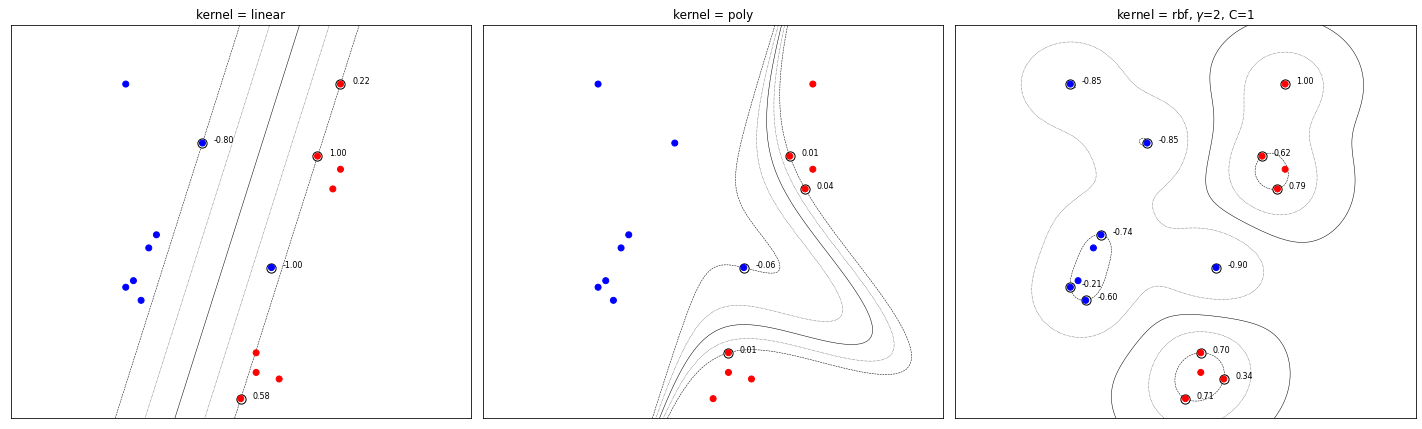

In [17]:
plot_svm_kernels(['linear', 'poly', 'rbf'],poly_degree=3,gamma=2,size=4)

### SVM with RBF kernel
* Every support vector _locally_ influences predictions, according to kernel width ($\gamma$)
* The prediction for test point $\mathbf{u}$: sum of the remaining influence of each support vector
    * $f(x) = \sum_{i=1}^{l} a_i y_i k(\mathbf{x_i},\mathbf{u})$

In [18]:
@interact
def plot_rbf_data(gamma=(0.1,10,0.5),C=(0.01,5,0.1)):
    plot_svm_kernels(['rbf'],gamma=gamma,C=C,size=4)

interactive(children=(FloatSlider(value=4.6, description='gamma', max=10.0, min=0.1, step=0.5), FloatSlider(va…

In [19]:
if not interactive:
    plot_svm_kernels(['rbf','rbf','rbf'],gamma=[0.1,1,5],size=4)

### Tuning RBF SVMs
* gamma (kernel width)
    * high values cause narrow Gaussians, more support vectors, overfitting
    * low values cause wide Gaussians, underfitting
* C (cost of margin violations)
    * high values punish margin violations, cause narrow margins, overfitting
    * low values cause wider margins, more support vectors, underfitting

In [20]:
%%HTML
<style>
.reveal img {
    margin-top: 0px;
}
</style>

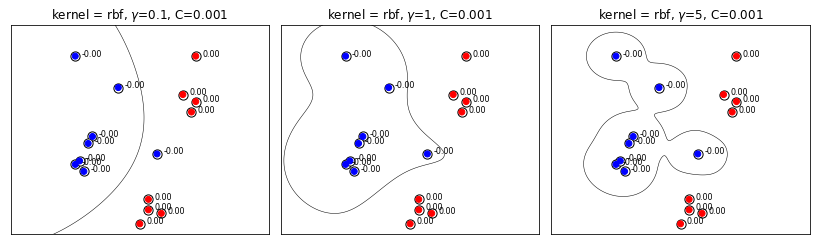

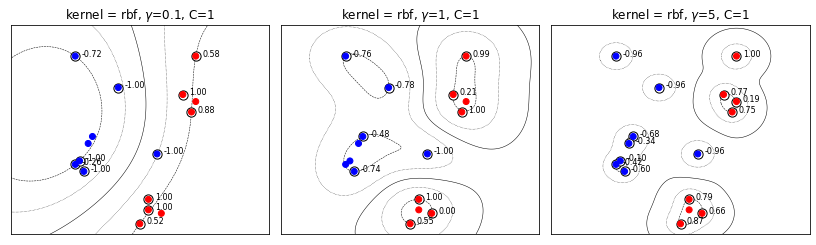

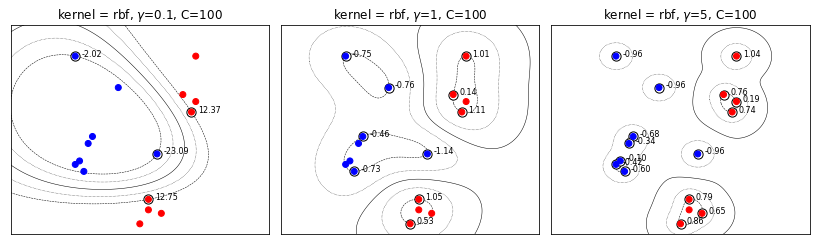

In [21]:
plot_svm_kernels(['rbf','rbf','rbf'],gamma=[0.1,1,5],C=0.001,size=2.3)
plot_svm_kernels(['rbf','rbf','rbf'],gamma=[0.1,1,5],C=1,size=2.3)
plot_svm_kernels(['rbf','rbf','rbf'],gamma=[0.1,1,5],C=100,size=2.3)

Kernel overview

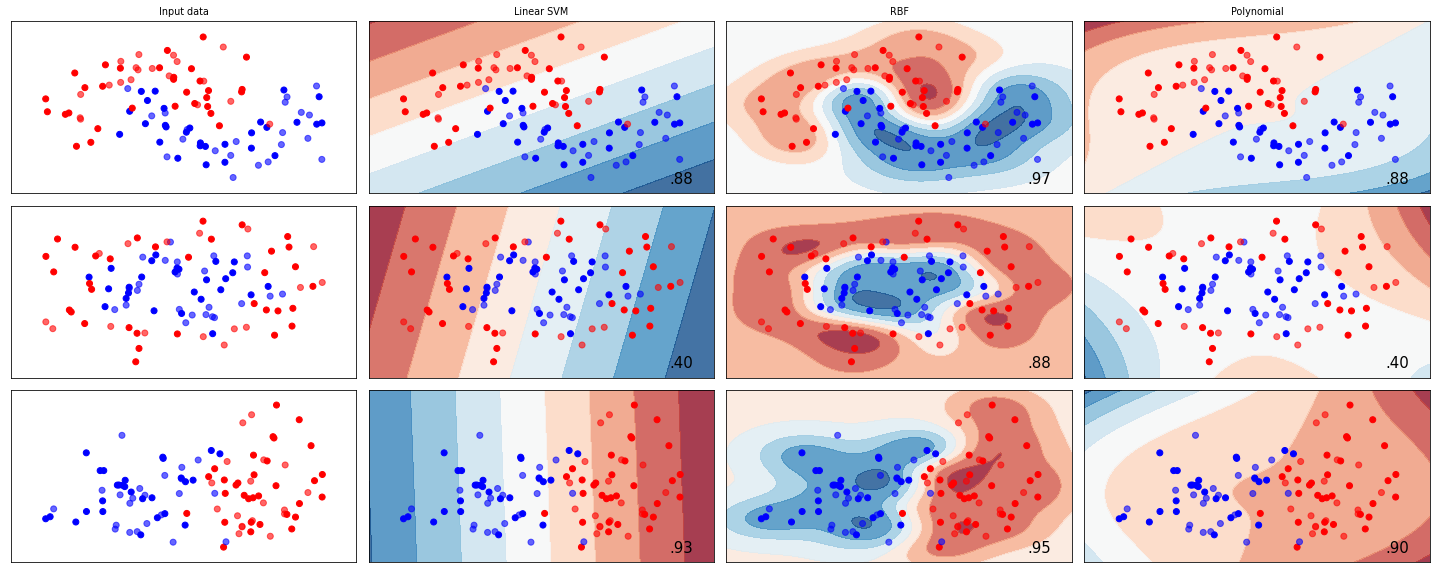

In [22]:
from sklearn.svm import SVC
names = ["Linear SVM", "RBF", "Polynomial"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel="poly", degree=3, C=0.1)
    ]
 
mglearn.plots.plot_classifiers(names, classifiers, figuresize=(20,8)) 

### SVMs in practice
* C and gamma _always_ need to be tuned 
    * Interacting regularizers. Find a good C, then finetune gamma
* SVMs expect all features to be approximately on the same scale
    * Data needs to be scaled beforehand
* Allow to learn complex decision boundaries, even with few features
    * Work well on both low- and high dimensional data
    * Especially good at small, high-dimensional data
* Hard to inspect, although support vectors can be inspected
* In sklearn, you can use `SVC` for classification with a range of kernels
    * `SVR` for regression

### Other kernels
* There are many more possible kernels
* If no kernel function exists, we can still _precompute_ the kernel matrix
    * All you need is some similarity measure, and you can use SVMs
* Text kernels: 
    * Word kernels: build a bag-of-words representation of the text (e.g. TFIDF)
        * Kernel is the inner product between these vectors
    * Subsequence kernels: sequences are similar if they share many sub-sequences
        * Build a kernel matrix based on pairwise similarities
* Graph kernels: Same idea (e.g. find common subgraphs to measure similarity)
* These days, deep learning embeddings are more frequently used

## The Representer Theorem
* We can kernelize many other loss functions as well
* The _Representer Theorem_ states that if we have a loss function $\mathcal{L}'$ with
    * $\mathcal{L}$ an _arbitrary_ loss function using some function $f$ of the inputs $\mathbf{x}$
    * $\mathcal{R}$ a (non-decreasing) regularization score (e.g. L1 or L2) and constant $\lambda$
$$\mathcal{\mathcal{L}'}(\mathbf{w}) = \mathcal{L}(y,f(\mathbf{x})) + \lambda \mathcal{R} (||\mathbf{w}||)$$

* Then the weights $\mathbf{w}$ can be described as a linear combination of the training samples:
$$\mathbf{w} = \sum_{i=1}^{n} a_i y_i f(\mathbf{x_i})$$
* Note that this is exactly what we found for SVMs: $ \mathbf{w} = \sum_{i=1}^{l} a_i y_i \mathbf{\mathbf{x_i}} $
* Hence, we can also kernelize Ridge regression, Logistic regression, Perceptrons, Support Vector Regression, ...

## Kernelized Ridge regression
* The linear Ridge regression loss (with $\mathbf{x_0}=1$):
    $$\mathcal{L}_{Ridge}(\mathbf{w}) = \sum_{i=0}^{n} (y_i-\mathbf{w}\mathbf{x_i})^2 + \lambda \| w \|^2$$ 
* Filling in $\mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x_i}$ yields the dual formulation:
    $$\mathcal{L}_{Ridge}(\mathbf{w}) = \sum_{i=1}^{n} (y_i-\sum_{j=1}^{n} \alpha_j y_j \mathbf{x_i}\mathbf{x_j})^2 + \lambda \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \mathbf{x_i}\mathbf{x_j}$$ 
* Generalize $\mathbf{x_i}\cdot\mathbf{x_j}$ to $k(\mathbf{x_i},\mathbf{x_j})$
    $$\mathcal{L}_{KernelRidge}(\mathbf{\alpha},k) = \sum_{i=1}^{n} (y_i-\sum_{j=1}^{n} \alpha_j y_j k(\mathbf{x_i},\mathbf{x_n}))^2 + \lambda \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j k(\mathbf{x_i},\mathbf{x_j})$$ 

### Example of kernelized Ridge
* Prediction (red) is now a linear combination of kernels (blue): $y = \sum_{j=1}^{n} \alpha_j y_j k(\mathbf{x},\mathbf{x_j})$
* We learn a dual coefficient for each point

In [23]:
import scipy.stats as stats
import math

@interact
def plot_kernel_ridge(gamma=(0.1,2,0.1),a1=(-1,1,0.1),a2=(-1,1,0.1),a3=(-1,1,0.1)):   
    xs = [-6,-4,-3,0,2,4]
    ys = [-0.3,0.05,-0.1,0.3,0.16,-0.05]
    alphas = [a1,a2,a3,.7,0.3,-0.2]
    p = np.linspace(-10, 10, 100)
    f = [0]*100
    for a,x,y in zip(alphas,xs,ys):
        k = stats.norm.pdf(p, x, 1/gamma)
        f += a*k
        plt.plot(p, k, 'b-')
        plt.annotate("%0.2f" % (a), (x+0.1,y+0.01), fontsize=10, zorder=11)
    plt.plot(p, f, 'r-', lw=2)
    plt.scatter(xs,ys);

interactive(children=(FloatSlider(value=1.0, description='gamma', max=2.0, min=0.1), FloatSlider(value=0.0, de…

In [24]:
if not interactive:
    plot_kernel_ridge(1,-.8,.5,-0.5)

* Fitting our regression data with `KernelRidge`

In [25]:
from sklearn.kernel_ridge import KernelRidge

@interact
def plot_kernel_ridge(gamma=(0.01,10,0.5)):
    X, y = mglearn.datasets.make_wave(n_samples=100)
    line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

    reg = KernelRidge(kernel='rbf', gamma=gamma).fit(X, y)
    plt.rcParams['figure.figsize'] = [8*fig_scale, 4*fig_scale]
    plt.plot(line, reg.predict(line), label="Kernel Ridge (RBF)", lw=2, c='r')

    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel("Regression output")
    plt.xlabel("Input feature")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=4.51, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _…

In [26]:
if not interactive:
    plot_kernel_ridge(5)

### Other kernelized methods
* Same procedure can be done for logistic regression
* For perceptrons, $\alpha \rightarrow \alpha+1$ after every misclassification
$$\mathcal{L}_{DualPerceptron}(x_i,k) = max(0,y_i \sum_{j=1}^{n} \alpha_j y_j k(\mathbf{x_j},\mathbf{x_i}))$$
* Support Vector Regression behaves similarly to Kernel Ridge

In [27]:
from sklearn.svm import SVR

@interact
def plot_kernel_ridge_svr(gamma=(0.01,10,0.5)):
    X, y = mglearn.datasets.make_wave(n_samples=100)
    line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

    reg = KernelRidge(kernel='rbf', gamma=gamma).fit(X, y)
    svr = SVR(kernel='rbf', gamma=gamma).fit(X, y)
    plt.rcParams['figure.figsize'] = [8*fig_scale, 4*fig_scale]
    plt.plot(line, reg.predict(line), label="Kernel Ridge (RBF)", lw=2, c='r')
    plt.plot(line, svr.predict(line), label="Support Vector Regression (RBF)", lw=2, c='r')

    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel("Regression output")
    plt.xlabel("Input feature")
    plt.legend(loc="best");

interactive(children=(FloatSlider(value=4.51, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _…

In [28]:
if not interactive:
    plot_kernel_ridge_svr(gamma=5)

## Summary
* Feature maps $\Phi(x)$ transform features to create a higher-dimensional space
    * Allows learning non-linear functions or boundaries, but very expensive/slow
* For some $\Phi(x)$, we can compute dot products without constructing this space
    * Kernel trick: $k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$
    * Kernel $k$ (generalized dot product) is a measure of similarity between $\mathbf{x_i}$ and $\mathbf{x_j}$
* There are many such kernels
    * Polynomial kernel: $k_{poly}(\mathbf{x_1},\mathbf{x_2}) = (\gamma (\mathbf{x_1} \cdot \mathbf{x_2}) + c_0)^d$
    * RBF (Gaussian) kernel: $k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}||^2)$
    * A kernel matrix can be precomputed using any similarity measure (e.g. for text, graphs,...)
* Any loss function where inputs appear only as dot products can be kernelized
    * E.g. Linear SVMs: simply replace the dot product with a kernel of choice
* The Representer theorem states which _other_ loss functions can also be kernelized and how
    * Ridge regression, Logistic regression, Perceptrons,...